In [1]:
import pandas as pd
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
df = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/all_subreddits.csv')

In [152]:
df.tail()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
249995,16802881,unemployment,1586483390,yeah believe right look great chart nevada put...,0.8402
249996,9285909,askreddit,1609412233,offense taken grew different circumstances gt ...,-0.5885
249997,10237762,iama,1606925404,james really good question answer two fold poo...,-0.9417
249998,12742373,asktrumpsupporters,1599704873,flip flopping covid information sure thoughts ...,0.3002
249999,6810474,formula1,1616861249,need covid,0.0000


In [57]:
df.dropna(axis = 0, how = 'any')

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,7951721,oakisland,1613168164,Carmen Legge was at the Northville Farm ([http...,0.0000
1,13261673,ukpolitics,1597987216,You don't need to be an expert to see that Bor...,0.0000
2,261403,amazonfc,1634437900,Just made a month! lol and I’ve worked at amaz...,0.7818
3,15681814,drugs,1590316428,It looks like you're discussing that thing. Co...,0.8391
4,3153614,politics,1628274205,"&gt;“Decent covid response” yes, killing the s...",0.7289
...,...,...,...,...,...
249995,16802881,unemployment,1586483390,Yeah I believe you are right.\n\nLook at the g...,0.8402
249996,9285909,askreddit,1609412233,"No offense taken, we all grew up under differe...",-0.5885
249997,10237762,iama,1606925404,"James here: Really good question. So, the answ...",-0.9417
249998,12742373,asktrumpsupporters,1599704873,Flip flopping on covid information. Not sure i...,0.3002


## Preprocessing

In [5]:
import re
import demoji 
demoji.download_codes()

/var/folders/q6/mkn146812pz0n3cx40bgg__40000gn/T/ipykernel_82667/79378484.py:3: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [6]:
def pre_cleaning(text):
    line = re.sub(r"\Bu/\w+", ' ', text) #remove usernames
    line = demoji.replace(line, repl=' ')
    return line

In [7]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stTem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
def post_cleaning(text):
    # Remove special characters
    feature = re.sub(r'\W', ' ',text)

    # remove single characters
    feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', feature)

    # Remove single characters from the start
    feature = re.sub(r'\^[a-zA-Z]\s+', ' ', feature) 
    
    #remove digits
    feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", feature)

    # Substituting multiple spaces with single space
    feature = re.sub(r'\s+', ' ', feature, flags=re.I)

    return feature

In [12]:
#above functions combined
def preprocessing(text):
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [58]:
df.body = df.body.apply(lambda x: preprocessing(x))

In [14]:
df.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,7951721,oakisland,1613168164,carmen legge northville farm centerville nova ...,0.0000
1,13261673,ukpolitics,1597987216,need expert see boris covid brexit fall guy,0.0000
2,261403,amazonfc,1634437900,made month lol worked amazon covid hit whole f...,0.7818
3,15681814,drugs,1590316428,looks like discussing thing contact medical em...,0.8391
4,3153614,politics,1628274205,gt decent covid response yes killing states ec...,0.7289


In [131]:
sample = df.sample(20000)

In [132]:
for sentiment in sample['sentiment']:
    if sentiment >= 0:
        sample['sentiment'].replace({sentiment : 'positive'}, inplace=True)
    if sentiment < 0:
        sample['sentiment'].replace({sentiment : 'negative'}, inplace=True)
#     else:
#         sample['sentiment'].replace({sentiment : 'neutral'}, inplace=True)

In [133]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
69702,5422921,byebyejob,1621004080,know since still living epidemic say maybe who...,negative
125000,2632806,greece,1629320803,000 covid bold,NaN
67734,12258202,pikabunews,1601381240,amp amp amp gt gt gt gt gt gt gt gt gt 09 gt g...,NaN
147882,16500020,raleigh,1587487242,defeat covid,negative
97704,11582626,bigbrother,1603270094,false covid test yeah ok,positive


Text(0.5, 1.0, 'Sentiment Data Distribution')

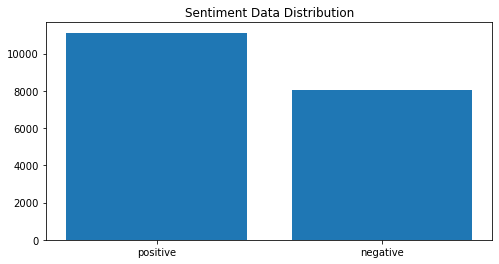

In [134]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [135]:
from sklearn.model_selection import train_test_split

In [136]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 16000
Test Data size 4000


## Model

In [22]:
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.preprocessing import LabelEncoder

In [80]:
lb=LabelEncoder()
sample['sentiment'] = lb.fit_transform(sample['sentiment'])

In [81]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(sample['body'].values)
X = tokenizer.texts_to_sequences(sample['body'].values)
X = pad_sequences(X, maxlen = 300)

In [49]:
X.shape

(20000, 600)

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
scaler.transform(X)

array([[ 0.        ,  0.        ,  0.        , ..., -0.89255323,
        -0.93275709,  0.06217387],
       [ 0.        ,  0.        ,  0.        , ..., -0.89255323,
        -0.59566449,  0.39334505],
       [ 0.        ,  0.        ,  0.        , ...,  1.32609308,
        -0.49525393, -0.52970655],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.70032104,
        -0.94710145, -0.41696742],
       [ 0.        ,  0.        ,  0.        , ..., -0.31655852,
        -0.05057859, -0.55789133],
       [ 0.        ,  0.        ,  0.        , ...,  1.00609602,
        -0.73910815, -0.2901359 ]])

In [82]:
y = sample['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [143]:
model = Sequential()
model.add(Embedding(X.shape[0], 64, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'BinaryCrossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 300, 64)           1280000   
                                                                 
 spatial_dropout1d_33 (Spati  (None, 300, 64)          0         
 alDropout1D)                                                    
                                                                 
 lstm_30 (LSTM)              (None, 176)               169664    
                                                                 
 dense_29 (Dense)            (None, 1)                 177       
                                                                 
Total params: 1,449,841
Trainable params: 1,449,841
Non-trainable params: 0
_________________________________________________________________
None


In [146]:
batch_size=128
model.fit(X_train, y_train, epochs = 3, batch_size=batch_size, verbose = 'auto')

Epoch 1/3
125/125 [==============================] - 190s 2s/step - loss: -1.1397 - accuracy: 0.6589
Epoch 2/3
125/125 [==============================] - 202s 2s/step - loss: -3.2096 - accuracy: 0.6793
Epoch 3/3
125/125 [==============================] - 201s 2s/step - loss: -5.6812 - accuracy: 0.6835


In [147]:
model.evaluate(X_test,y_test)

125/125 [==============================] - 14s 111ms/step - loss: -7.1091 - accuracy: 0.6690


[-7.109106540679932, 0.6690000295639038]

## Plot Sentiment Over Time

In [ ]:
plt.figure(1,figsize=(30,8))

plt.subplot(131)
 #Code for fig1.
plt.subplot(132)
#code for fig2
plt.subplot(133)
#code for fig3.
plt.show()

In [169]:
plot_sample = df.sample(2000)
plot_sample = plot_sample.sort_values("created_utc")
plot_sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
106007,17771285,coronavirus,1582155722,influenza pnuemonia hospitalization death rate...,0.3633
59445,17769138,coronavirus,1582350408,h1n1 definitely sars yes right however already...,0.6440
188182,17762019,coronavirus,1582710878,gt covid want treated china people treated chi...,-0.5574
98811,17754966,askreddit,1582874905,know symptoms think far average person concern...,-0.9238
225391,17748188,nyc,1583006468,agree think good op quarantine think cdc smart...,0.8074


In [170]:
plot_sample = plot_sample.astype({"sentiment": str})

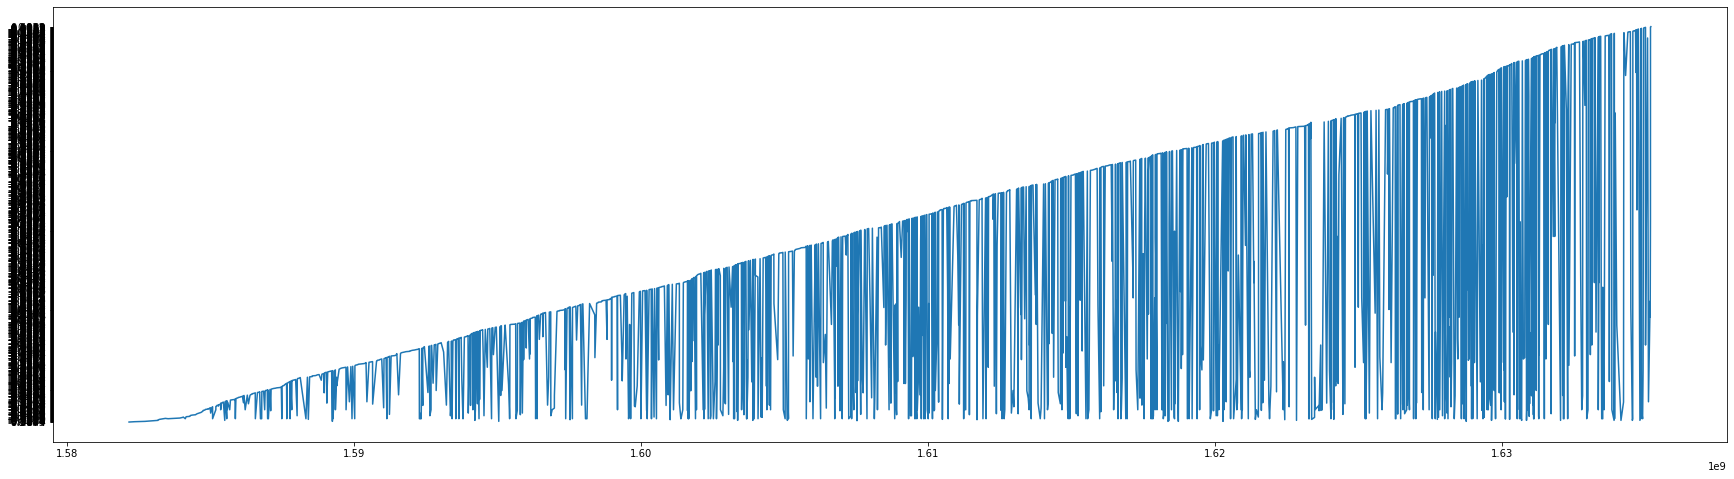

In [171]:
plt.figure(1,figsize=(30,8))

x = plot_sample['created_utc']
y = plot_sample['sentiment']

plt.plot(x,y)

plt.show()

In [258]:
train_data = train_data.reset_index()
test_data = test_data.reset_index()

In [154]:
bs = 64
cut = int(50000 * 0.8)
dls = DataLoaders.from_dsets(train_data, test_data, bs=64, shuffle=False)

NameError: name 'DataLoaders' is not defined

In [153]:
class LModel(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

NameError: name 'Module' is not defined

In [39]:
vocab = vectorizer.get_feature_names()

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [150]:
import torch

In [148]:
learn = Learner(dls, LModel(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

NameError: name 'Learner' is not defined